# Imports

In [33]:
import pm4py
import pandas as pd
import numpy as np
from pm4py.objects.conversion.log import converter as log_converter
from matplotlib import pyplot as plt

from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Reshape, GaussianNoise, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Data Preprocessing
We load the XES-File and convert it to a pandas DataFrame. We drop irrelevant columns and rename the remaining ones. We make sure that every ID is unique so that identical IDs of different elicitations don't overlap. 

In [2]:
def load_data(file_names):
    """Loads the event logs provided in file_names,
    adjusts the column names and concats them to one DataFrame."""
    df_total = pd.DataFrame()
    id_count = 0
    for file in file_names:
        xes_file = pm4py.read_xes('../Daten/Activities of daily living of several individuals/' + file)
        file_as_df = log_converter.apply(xes_file, variant=log_converter.Variants.TO_DATA_FRAME)
        file_as_df = file_as_df[['concept:name', 'lifecycle:transition', 'time:timestamp', 'case:concept:name']]
        file_as_df.columns = ['action', 'status', 'time', 'id']
        for i in list(file_as_df.id.unique()):
            file_as_df.loc[file_as_df['id'] == i, 'id'] = id_count
            id_count += 1
        df_total = df_total.append(file_as_df)
    return df_total

file_names = ['activitylog_uci_detailed_labour.xes',
              'activitylog_uci_detailed_weekends.xes',
              'edited_hh102_labour.xes',
              'edited_hh102_weekends.xes',
              'edited_hh104_labour.xes',
              'edited_hh104_weekends.xes',
              'edited_hh110_labour.xes',
              'edited_hh110_weekends.xes']

df = load_data(file_names)

We parse the correct datatype for each column and transform the timestamp column to a duration in seconds. Afterwards, the activities are aggregated so that there exist no synonymous naming conventions (e.g. compare watchingtv and watchtv)

In [3]:
def convert_datatypes(df, datatypes, time_column):
    """Converts the columns of a dataframe to the
    types specified in datatypes. Also transforms
    the time_column to a datetime type."""
    df[time_column] = pd.to_datetime(df[time_column], 
                                     utc = True)
    df = df.astype(datatypes)
    return df

def convert_timestamps_to_duration(df):
    """Converts the start and completion timestamps
    of an event to one duration in seconds."""
    time_differences = []
    for i in range(1, len(df), 2):
        start = df.iloc[i-1, 2]
        complete = df.iloc[i, 2]
        duration = (complete - start).total_seconds()
        time_differences.extend([duration, duration])
    df['duration'] = time_differences
    df = df.iloc[::2, [0,3,4]].reset_index(drop=True)
    return df

def aggregate_activities(row):
    """Aggregates activities like e.g. prepareDinner,
    prepareBreakfast, prepareLunch to a single activity
    mealpreparation."""
    agg_dict = {'grooming' : 'groom',
                'watchingtv' : 'watchtv',
                'sleeping' : 'sleep',
                'prepareBreakfast' : 'mealpreparation',
                'prepareLunch' : 'mealpreparation',
                'prepareDinner' : 'mealpreparation',
                'mealpreperation' : 'mealpreparation',
                'eatingBreakfast' : 'eatingdrinking',
                'eatingLunch' : 'eatingdrinking',
                'eatingDinner' : 'eatingdrinking',
                'drink' : 'eatingdrinking',
                'drinking' : 'eatingdrinking'}
    if row['action'] in agg_dict.keys():
        return agg_dict[row['action']]
    else:
        return row['action']


datatypes = {'action' : 'category',
             'status' : 'category',
             'id' : 'category'}
df = convert_datatypes(df, datatypes, 'time')
df = convert_timestamps_to_duration(df)
df['action'] = df.apply(aggregate_activities, axis=1)

# Data Exploration
We apply some basic data exploration techniques to gain a deeper understanding for the dataset

In [6]:
df.head(10)

,action,id,duration
0,Start,0,0.0
1,washing,0,94.0
2,watchtv,0,3703.0
3,toilet,0,3.0
4,washing,0,8.0
5,toilet,0,18.0
6,sleep,0,27370.0
7,toilet,0,229.0
8,mealpreparation,0,480.0
9,eatingdrinking,0,176.0


Amount of rows, amount of different activities and average duration

In [7]:
print('Length of dataset:', len(df), 'rows')
print('Different unique activities:', len(df.action.unique()))
print('Different unique IDs:', len(df.id.unique()))
print('Average duration of a single activity:', int(df.duration.mean()), 'seconds')

Length of dataset: 5569 rows
Different unique activities: 22
Different unique IDs: 148
Average duration of a single activity: 1893 seconds


In [8]:
temp = pd.DataFrame(df.groupby(by='action')['duration'].mean().sort_values())
temp['action'] = temp.index
temp = temp[['action', 'duration']]
temp.columns = ['action', 'Average Duration']
temp = temp.reset_index(drop=True)
temp

,action,Average Duration
0,Start,0.000000
1,washing,146.596386
2,medication,265.276498
3,groom,313.263804
4,dress,363.564103
5,toilet,364.310219
6,shower,398.000000
7,cleaning,432.487179
8,bathe,467.760000
9,End,568.661972


Average durations grouped by every activity

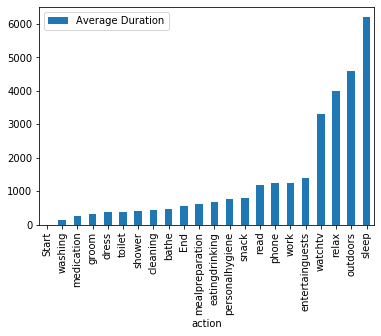

In [9]:
temp.plot.bar(x='action', y='Average Duration')

In [10]:
df[(df['duration'] > 0) & (df['action'] == 'End')]

,action,id,duration
424,End,13,80750.0


Apart from one row the activity start and end always have the duration 0. Since the single row with a longer duration takes more than 22 hours, we assume it is a error in the data and will therefore be set to zero.

In [11]:
df.loc[(df['duration'] > 0) & (df['action'] == 'End'), 'duration'] = 0.0

We explore how many actions a ID contains on average

In [12]:
df.groupby('id')['action'].agg('count').mean()

37.62837837837838

In [13]:
df[df['id'] == 0].duration.sum()

79871.0

In [14]:
df.groupby('id')['duration'].agg('sum').mean()/60/60

19.639491366366368

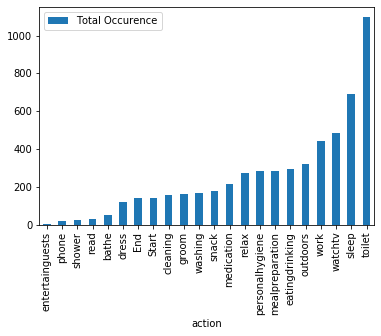

In [15]:
temp = pd.DataFrame(df.groupby('action')['action'].count().sort_values())
temp.columns = ['Total Occurence']
temp['action'] = temp.index
temp.columns = ['Total Occurence', 'action']
temp = temp[['action', 'Total Occurence']]
temp = temp.reset_index(drop=True)
temp.plot.bar(x='action', y='Total Occurence')

In [10]:
temp.to_excel('../Daten/total_occurence_per_action.xlsx', index=False)

# Variable Transformation
We now transform our variables: We choose the following transformation methods:
- action : OneHotEncoder
- id : OneHotEncoder
- all variables (after encoding) : MinMaxScaler

In [16]:
def fit_encoders(df):
    """Fits the OneHotEncoder on all categorical values."""
    encoder_action = OneHotEncoder(sparse=False)
    encoder_action.fit(df.action.to_numpy().reshape(-1,1))
    encoder_id = OneHotEncoder(sparse=False)
    encoder_id.fit(df.id.to_numpy().reshape(-1,1))
    return encoder_action, encoder_id

def fit_scaler(df):
    """Fits the MinMaxScaler on all numerical values."""
    scaler_duration = MinMaxScaler(feature_range=(-1, 1))
    scaler_duration.fit(df.duration.to_numpy().reshape(-1,1))
    return scaler_duration

def transform_variables(df):
    """Encodes the categorical variables and normalizes
    the numerical variables to a range between 0 and 1."""
    encoder_action, encoder_id = fit_encoders(df)
    scaler_duration = fit_scaler(df)
    id_transformed = encoder_id.transform(df.id.to_numpy().reshape(-1,1))
    action_transformed = encoder_action.transform(df.action.to_numpy().reshape(-1,1))
    duration_transformed = scaler_duration.transform(df.duration.to_numpy().reshape(-1,1))
    transformed = np.hstack((id_transformed, action_transformed, duration_transformed))
    return transformed

data_transformed = transform_variables(df)

In [18]:
data_transformed.shape

(5569, 171)

# Creation of dataset
After transforming our variables, we now reshape our input data for the LSTM network. This means, for each id of the dataframe we pick 5 Timesteps in a sequence as input and define the 6th timestep as the label for the preceding timesteps. We repeat this step until we reached the last 6 timesteps

In [19]:
def split_data_into_sequences(data, sequence_length):
    """Splits the provided data into sequences of
    length sequence_length."""
    sequences = []
    for i in range(0, data.shape[0]-sequence_length+1):
        sequence = data[i : i + sequence_length, :]
        sequence = sequence.reshape(1, sequence_length, -1)
        sequences.append(sequence)
    sequences = np.vstack((sequences))
    return sequences

sequences = split_data_into_sequences(data_transformed, 20)

In [20]:
sequences.shape

(5550, 20, 171)

# Creation of the Generative Adversarial Network
We now define the functionalities for creating a GAN. 

In [30]:
def define_discriminator(data):
    """Create and compile the discriminator."""
    discriminator = Sequential()
    discriminator.add(GaussianNoise(0.1))
    discriminator.add(LSTM(64, input_shape=(data.shape[1], data.shape[2])))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return discriminator

def define_generator(latent_shape):
    """Create the generator with latent_shape as 
    input shape."""
    model = Sequential()
    model.add(LSTM(4000, input_shape=latent_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    model.add(Dense(3420, activation='tanh'))
    model.add(Reshape((20,171)))
    return model

def define_gan(g_model, d_model):
    """Define the GAN as a combination of the generator 
    and discriminator model."""
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def generate_real_samples(dataset, n_samples):
    """Randomly pick n real samples of our dataset."""
    indices = np.random.randint(0, dataset.shape[0], n_samples)
    x = dataset[indices]
    y = np.ones((n_samples, 1))
    return x, y

def generate_latent_points(n_samples):
    """Generates n samples in the latent space."""
    x = np.random.randn(n_samples, 20, 171)
    return x

def generate_fake_samples(g_model, n_samples):
    """Generates fake samples with the generator."""
    x_input = generate_latent_points(n_samples)
    x = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return x, y

def train(g_model, d_model, gan_model, dataset, epochs, batch_size):
    """Trains the generator and discriminator."""
    batches_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    
    for epoch in range(epochs):
        for batch in range(batches_per_epoch):
            x_real, y_real = generate_real_samples(dataset, half_batch)
            x_fake, y_fake = generate_fake_samples(g_model, half_batch)
            x_discriminator, y_discriminator = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(x_discriminator, y_discriminator)
            x_gan = generate_latent_points(batch_size)
            y_gan = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(x_gan, y_gan)
            monitor_progress(epoch, batch, batches_per_epoch, d_loss, g_loss, dataset,
                            g_model, d_model)

gen_loss = []
disc_loss = []
def monitor_progress(epoch, batch, batches_per_epoch, d_loss, g_loss, dataset, g_model, d_model):
    """Prints out accuracy and loss of the GAN and saves
    the model every 10 epochs."""
    print('>%d, %d/%d, d=%.3f, g=%.3f' % (epoch+1, batch+1, batches_per_epoch, d_loss, g_loss))
    gen_loss.append(g_loss)
    disc_loss.append(d_loss)
    if ((epoch + 1) % 10 == 0):
        x_real, y_real = generate_real_samples(dataset, 100)
        _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
        x_fake, y_fake = generate_fake_samples(g_model, 100)
        _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
        print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
        filename = 'model_%03d.h5' % (epoch + 1)
        g_model.save('../Models/' + filename)

In [ ]:
# create the discriminator
d_model = define_discriminator(sequences)
# create the generator
g_model = define_generator((20,171))
# create the gan
gan_model = define_gan(g_model, d_model)
# train model
train(g_model, d_model, gan_model, sequences, 1000, 256)

# Generate synthetic dataset

In [52]:
def translate_result(generated):
    """Decodes the resulting vector into a human readable format."""
    encoder_action, encoder_id = fit_encoders(df)
    scaler_duration = fit_scaler(df)
    res = []
    for i in range(generated.shape[0]):
        for j in range(generated.shape[1]):
            temp = generated[i,j]
            id_temp = temp[0:148]
            action_temp = temp[148:148+22]
            duration_temp = temp[-1]
            id_inverse = encoder_id.inverse_transform(id_temp.reshape(1,-1))[0][0]
            action_inverse = encoder_action.inverse_transform(action_temp.reshape(1,-1))[0][0]
            duration_inverse = scaler_duration.inverse_transform(duration_temp.reshape(1,-1))[0][0]
            res.append([id_inverse, action_inverse, duration_inverse])
    res = pd.DataFrame(res, columns = ['id', 'action', 'duration']).sort_values(by='id')
    return res

def drop_consecutive_duplicates(data):
    """Drops consecutive duplicates and adds their duration up."""
    indices = [0]
    for i in range(1, len(data)):
        if (data.iloc[i, [0,1]] == data.iloc[i-1, [0,1]]).all():
            continue
        else:
            indices.append(i)
    return data.iloc[indices].reset_index(drop=True)

def correct_start_end(data):
    """Makes sure that the start and end activitiy are at the right position
    and also corrects their duration."""
    new = pd.DataFrame(columns = ['id', 'action', 'duration'])
    for i in data.id.unique():
        start = pd.DataFrame([[i, 'Start', 0.0]], columns = ['id', 'action', 'duration'])
        end = pd.DataFrame([[i, 'End', 0.0]], columns = ['id', 'action', 'duration'])
        temp = data[data['id'] == i]
        temp = temp[~temp['action'].isin(['Start', 'End'])]
        correct = start.append(temp).append(end)
        new = new.append(correct).reset_index(drop=True)
    return drop_consecutive_duplicates(new)

In [51]:
# load model
model = load_model('../Models/model_040.h5')
# generate images
latent_points = generate_latent_points(5)
# generate images
X = model.predict(latent_points)

In [53]:
translated = translate_result(X)
translated = drop_consecutive_duplicates(translated)
translated = correct_start_end(translated)

In [70]:
translated.head(16)

,id,action,duration
0,121,Start,0.0
1,121,sleep,217.0
2,121,toilet,5861.0
3,121,groom,9082.0
4,121,work,5118.0
5,121,sleep,255.0
6,121,relax,9744.0
7,121,watchtv,5447.0
8,121,personalhygiene,276.0
9,121,work,5575.0


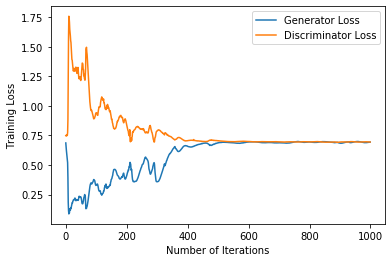

In [61]:
plt.plot(gen_loss[:1000], label='Generator Loss')
plt.plot(disc_loss[:1000], label='Discriminator Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig('large_model_loss.png')
plt.show()